In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import xarray as xr
import numpy as np
import seaborn as sns

import matplotlib

In [2]:
pd.__version__
xr.__version__
np.__version__
sns.__version__

sns.set_style('whitegrid')
#matplotlib.rcParams['figure.figsize'] = (15, 10)

'1.4.2'

'2022.3.0'

'1.22.3'

'0.11.2'

# R

In [3]:
import os
os.environ["R_HOME"] = "C:\\Program Files\\R\\R-4.1.3\\"

In [4]:
import os
import rpy2
from rpy2.robjects import r
from rpy2.robjects.packages import importr

In [5]:
%load_ext rpy2.ipython

C:\ProgramData\Anaconda3\envs\q2022\lib\site-packages\rpy2\robjects\packages.py:366: UserWarning: The symbol 'quartz' is not in this R namespace/package.
  warnings.warn(


In [6]:
from rpy2.robjects import pandas2ri
pandas2ri.activate()

In [7]:
#import pandas as pd
#import rpy2.robjects as ro
#from rpy2.robjects.conversion import localconverter
#%Rdevice png
#import rpy2.ipython.html
#rpy2.ipython.html.init_printing()

In [8]:
import rpy2.situation
[print(row) for row in rpy2.situation.iter_info()];

rpy2 version:
3.4.5
Python version:
3.9.11 (main, Mar 30 2022, 02:45:55) [MSC v.1916 64 bit (AMD64)]
Looking for R's HOME:
    Environment variable R_HOME: C:\Program Files\R\R-4.1.3\
    InstallPath in the registry: C:\Program Files\R\R-4.1.3
    Environment variable R_USER: None
    Environment variable R_LIBS_USER: None
R version:
    In the PATH: 
    Loading R library from rpy2: OK
Additional directories to load R packages from:
None
C extension compilation:


In [9]:
%R .libPaths()
%R R.home()
%R Sys.getenv('R_HOME')

'C:/Program Files/R/R-4.1.3/library'


'C:/Program Files/R/R-4.1.3/'


'C:/Program Files/R/R-4.1.3/'


Exception ignored from cffi callback <function _consolewrite_ex at 0x0000020666DA19D0>:
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\envs\q2022\lib\site-packages\rpy2\rinterface_lib\callbacks.py", line 132, in _consolewrite_ex
    s = conversion._cchar_to_str_with_maxlen(buf, n, _CCHAR_ENCODING)
  File "C:\ProgramData\Anaconda3\envs\q2022\lib\site-packages\rpy2\rinterface_lib\conversion.py", line 133, in _cchar_to_str_with_maxlen
    s = ffi.string(c, maxlen).decode(encoding)
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe4 in position 297: invalid continuation byte


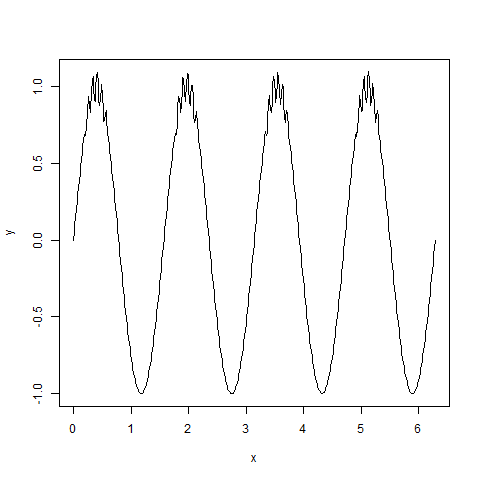

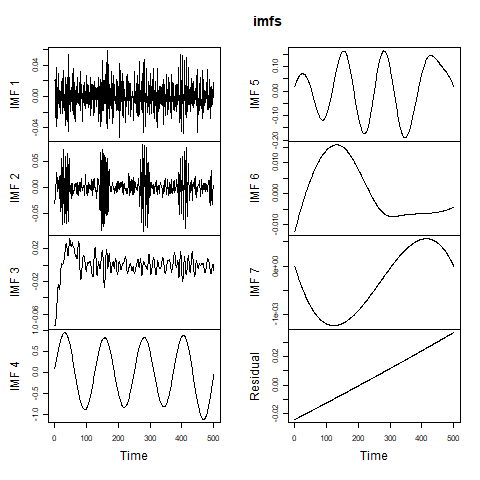

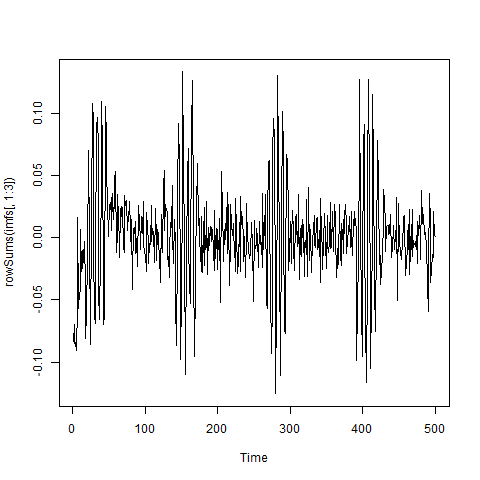

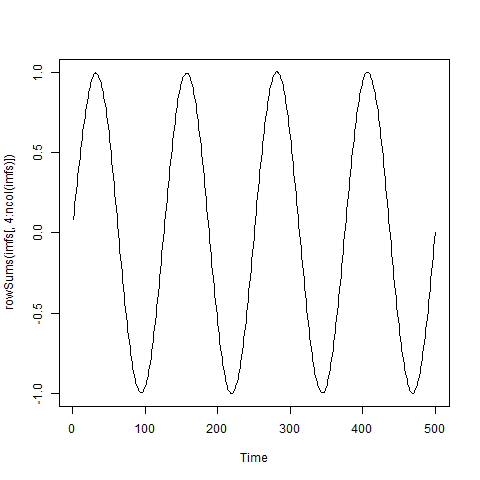

In [10]:
%%R

library(Rlibeemd)

x <- seq(0, 2*pi, length.out = 500)
signal <- sin(4*x)
intermittent <- 0.1 * sin(80 * x)
y <- signal * (1 + ifelse(signal > 0.7, intermittent, 0))
plot(x = x,y = y,type = "l")
# Decompose with EEMD
imfs <- eemd(y, num_siftings = 10, ensemble_size = 50, threads = 1)
plot(imfs)
# High frequencies
ts.plot(rowSums(imfs[, 1:3]))
# Low frequencies
ts.plot(rowSums(imfs[, 4:ncol(imfs)]))

# get data

In [10]:
data = pd.read_pickle("all.pkl")
cols = ['gold', 'silver', 'aqr_stocks', 'aqr_bonds', 'aqr_comm',
       'sbbi_stocks', 'sbbi_small_caps', 'sbbi_corp', 'sbbi_govt_20',
       'sbbi_govt_5', 'sbbi_rf']
data = data.dropna()[cols]

sorted(np.linalg.eig(data.corr())[0])
data.shape

[0.12535143329114543,
 0.1578940796528719,
 0.261877744662402,
 0.3892053899819116,
 0.42474475172639126,
 0.49681543764403024,
 0.7421123169661688,
 1.0015335449217553,
 1.6042014986952013,
 2.5933991819956246,
 3.202864620462508]

(1126, 11)

<AxesSubplot:ylabel='Density'>

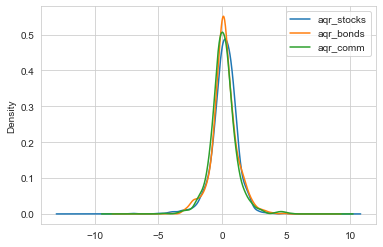

<AxesSubplot:>

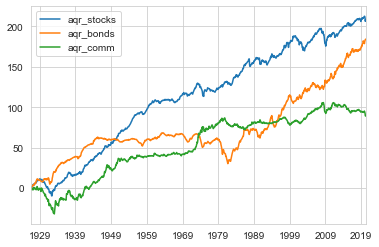

<AxesSubplot:>

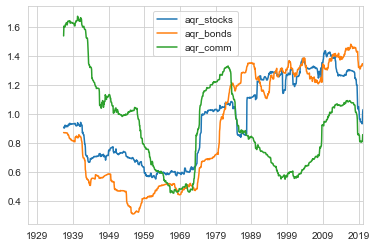

<AxesSubplot:>

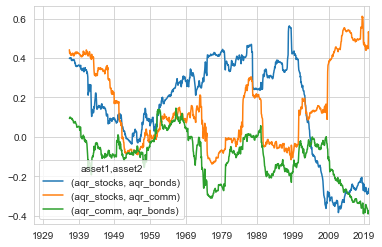

In [11]:
data = data[["aqr_stocks", "aqr_bonds", "aqr_comm"]].dropna()
data = data / data.std()
data.plot.kde()
plt.show()
data.cumsum().plot()
plt.show()
data.rolling(10*12).std().plot()
plt.show()
a = data.rolling(10*12).corr().unstack(1)
a.columns.names = ["asset1", "asset2"]
ai = [(i, j) for i, j in a.columns.to_list() if i>j]
a[ai].plot()
plt.show()

# EMD IMF

In [32]:
emd = importr("Rlibeemd")

In [33]:
imfs = {
    d: pd.DataFrame(emd.eemd(
        data[d],
        noise_strength=1.,
        #num_siftings=10,
        #num_imfs=5,
    ), index=data.index)
    for d in data
}

imfs = pd.concat(imfs, keys=data.columns).stack().rename("value")
imfs.index.names=["asset", "date", "imf"]

<AxesSubplot:>

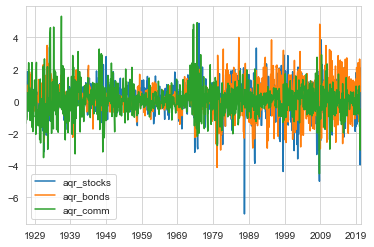

In [34]:
data.plot()

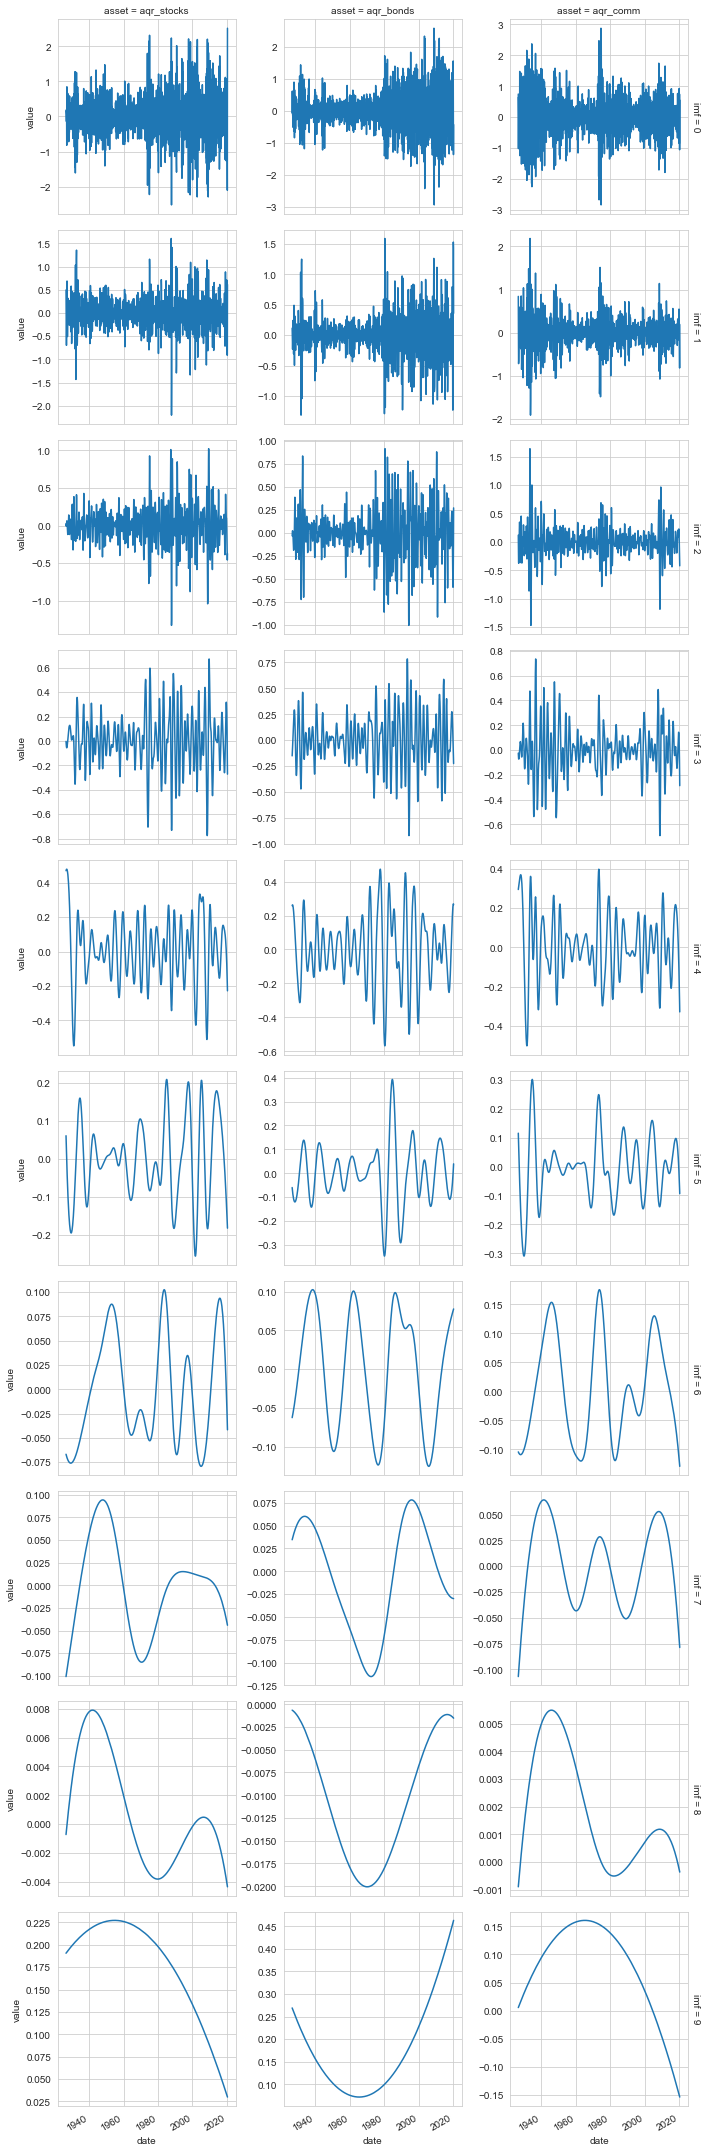

In [35]:
imfx = imfs.to_xarray()
imfx.plot(x="date", col="asset", row="imf", sharey=False)

In [36]:
def imf_oscillating_period(imfx):
    sign_changes = -(imfx * imfx.shift(date=1)).pipe(np.sign)
    c_extremes = sign_changes.where(sign_changes==1).sum("date") + 1
    period = imfx.date.size / c_extremes
    return period.round().to_pandas()

imf_oscillating_period(imfx)

imf,0,1,2,3,4,5,6,7,8,9
asset,,,,,,,,,,
aqr_stocks,2.0,3.0,6.0,14.0,26.0,56.0,125.0,225.0,225.0,1126.0
aqr_bonds,1.0,3.0,6.0,14.0,29.0,56.0,141.0,282.0,1126.0,1126.0
aqr_comm,1.0,3.0,6.0,13.0,27.0,47.0,125.0,161.0,225.0,563.0


In [37]:
c = imfx.to_series().unstack(["asset", "imf"]).corr().loc["aqr_stocks", "aqr_bonds"]
c.style.background_gradient(axis=None, cmap="bwr", vmin=-1, vmax=1)

imf,0,1,2,3,4,5,6,7,8,9
imf,,,,,,,,,,
0,0.084333,0.026849,0.003698,-0.010691,-0.004655,-0.005377,0.005618,0.007628,0.006726,0.007428
1,0.039100,0.079457,0.005440,0.005432,-0.004260,-0.008899,0.006803,0.002494,-0.002998,-0.000749
2,0.010127,-0.039324,0.058584,0.008334,-0.005876,-0.009085,-0.000660,0.002556,-0.006277,-0.011192
3,0.001161,-0.018895,0.027678,0.212064,0.061900,-0.012975,0.004468,0.002426,0.007041,0.010926
4,0.003154,-0.005203,-0.001778,0.056226,0.169192,0.012703,-0.040120,0.016810,0.053426,0.058454
5,0.001312,-0.001721,0.018715,-0.005167,0.179416,0.533169,0.093042,-0.033520,0.011085,0.064536
6,-0.000012,-0.003753,0.009837,-0.006377,0.013112,0.247424,0.066418,-0.159004,-0.127257,-0.017560
7,0.004285,-0.003618,0.010705,-0.018703,-0.021429,0.040621,0.023866,0.489528,0.227193,-0.022910
8,0.001539,-0.007358,0.008924,-0.016254,-0.038760,0.034219,0.086093,0.375705,0.304319,-0.127568


<AxesSubplot:xlabel='date'>

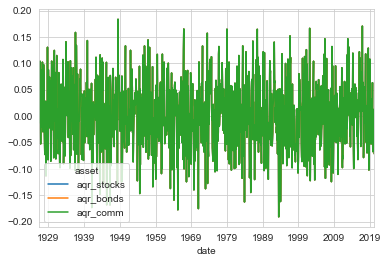

In [38]:
is_complete = imfx.sum("imf").T.to_pandas() - data
is_complete.plot()

# BEMD

In [26]:
a = data["aqr_stocks"] + 1j*data["aqr_bonds"]
emd = importr("Rlibeemd")
rpy2.robjects.globalenv["a"] = a
res = rpy2.robjects.r("res = data.frame(bemd(a))")
res

,IMF.1,IMF.2,IMF.3,IMF.4,IMF.5,IMF.6,IMF.7,IMF.8,IMF.9,Residual
1,0.052238+0.083188j,-0.180711-0.482473j,0.865857+0.357593j,-0.015559-0.007163j,0.321387+0.164606j,-0.018599+0.387686j,-0.575054-0.531873j,0.748056+0.259776j,-0.109501-0.055458j,0.158251+0.123646j
2,0.080443+0.357705j,0.325368+0.512189j,-0.303179-0.220224j,-0.038421-0.021827j,0.258331+0.030173j,-0.022507+0.407885j,-0.472652-0.410425j,0.676681+0.216178j,-0.101566-0.040572j,0.156049+0.126151j
3,-0.199729-0.321668j,0.475639+0.420956j,-0.776852-0.380730j,-0.039229-0.019433j,0.197283-0.082456j,-0.025774+0.419159j,-0.375517-0.298195j,0.607644+0.174507j,-0.093829-0.026209j,0.153902+0.128659j
4,-0.206920+0.102460j,0.195063-0.045560j,-0.732300-0.264028j,-0.023953-0.004800j,0.138919-0.174162j,-0.028458+0.422111j,-0.283581-0.194903j,0.540914+0.134730j,-0.086288-0.012362j,0.151813+0.131170j
5,0.484016+0.105391j,-0.375058-0.248990j,-0.346662-0.010217j,0.001434+0.017253j,0.083915-0.245825j,-0.030620+0.417346j,-0.196774-0.100270j,0.476462+0.096814j,-0.078942+0.000974j,0.149779+0.133683j
...,...,...,...,...,...,...,...,...,...,...
1122,-0.113096-1.106201j,0.936886+0.007202j,0.160852-0.476357j,-0.533450-0.528189j,0.212089-0.206570j,0.397425+0.076540j,-0.092566+0.138406j,0.152051-0.045891j,-0.193046+0.232994j,-0.485347+0.606674j
1123,0.383196+1.284927j,0.289869+1.551640j,-0.157364-0.606794j,-0.468285-0.462345j,0.136877-0.157760j,0.349237+0.039161j,-0.098040+0.140303j,0.147709-0.038898j,-0.225880+0.275714j,-0.509240+0.610349j
1124,0.183686-1.013378j,-1.170603+2.365922j,-0.381469-0.601839j,-0.295180-0.268534j,0.027788-0.073229j,0.282888-0.002038j,-0.101659+0.140349j,0.142089-0.031417j,-0.259961+0.320219j,-0.533581+0.614040j
1125,-1.288536-1.462116j,-1.543945+1.305332j,-0.405474-0.410218j,0.005823+0.079625j,-0.118932+0.051810j,0.196982-0.047074j,-0.103268+0.138408j,0.135147-0.023443j,-0.295306+0.366538j,-0.558372+0.617748j


In [27]:
res_stocks = pd.DataFrame(np.real(res), columns=res.columns, index=a.index)
res_bonds = pd.DataFrame(np.imag(res), columns=res.columns, index=a.index)
bimfs = pd.concat([res_stocks, res_bonds], axis=1, keys=["aqr_stocks", "aqr_bonds"])
bimfs

aqr_stocks                                                    \
                IMF.1     IMF.2     IMF.3     IMF.4     IMF.5     IMF.6   
1926-07-31   0.052238 -0.180711  0.865857 -0.015559  0.321387 -0.018599   
1926-08-31   0.080443  0.325368 -0.303179 -0.038421  0.258331 -0.022507   
1926-09-30  -0.199729  0.475639 -0.776852 -0.039229  0.197283 -0.025774   
1926-10-31  -0.206920  0.195063 -0.732300 -0.023953  0.138919 -0.028458   
1926-11-30   0.484016 -0.375058 -0.346662  0.001434  0.083915 -0.030620   
...               ...       ...       ...       ...       ...       ...   
2019-12-31  -0.113096  0.936886  0.160852 -0.533450  0.212089  0.397425   
2020-01-31   0.383196  0.289869 -0.157364 -0.468285  0.136877  0.349237   
2020-02-29   0.183686 -1.170603 -0.381469 -0.295180  0.027788  0.282888   
2020-03-31  -1.288536 -1.543945 -0.405474  0.005823 -0.118932  0.196982   
2020-04-30   1.406771  1.453854 -0.123389  0.454680 -0.307033  0.090124   

                                                   aqr_bonds            \
               IMF.7     IMF.8     IMF.9  Residual     IMF.1     IMF.2   
1926-07-31 -0.575054  0.748056 -0.109501  0.158251  0.083188 -0.482473   
1926-08-31 -0.472652  0.676681 -0.101566  0.156049  0.357705  0.512189   
1926-09-30 -0.375517  0.607644 -0.093829  0.153902 -0.321668  0.420956   
1926-10-31 -0.283581  0.540914 -0.086288  0.151813  0.102460 -0.045560   
1926-11-30 -0.196774  0.476462 -0.078942  0.149779  0.105391 -0.248990   
...              ...       ...       ...       ...       ...       ...   
2019-12-31 -0.092566  0.152051 -0.193046 -0.485347 -1.106201  0.007202   
2020-01-31 -0.098040  0.147709 -0.225880 -0.509240  1.284927  1.551640   
2020-02-29 -0.101659  0.142089 -0.259961 -0.533581 -1.013378  2.365922   
2020-03-31 -0.103268  0.135147 -0.295306 -0.558372 -1.462116  1.305332   
2020-04-30 -0.102711  0.126835 -0.331934 -0.583618  1.838001 -2.892600   

                                                                        \
               IMF.3     IMF.4     IMF.5     IMF.6     IMF.7     IMF.8   
1926-07-31  0.357593 -0.007163  0.164606  0.387686 -0.531873  0.259776   
1926-08-31 -0.220224 -0.021827  0.030173  0.407885 -0.410425  0.216178   
1926-09-30 -0.380730 -0.019433 -0.082456  0.419159 -0.298195  0.174507   
1926-10-31 -0.264028 -0.004800 -0.174162  0.422111 -0.194903  0.134730   
1926-11-30 -0.010217  0.017253 -0.245825  0.417346 -0.100270  0.096814   
...              ...       ...       ...       ...       ...       ...   
2019-12-31 -0.476357 -0.528189 -0.206570  0.076540  0.138406 -0.045891   
2020-01-31 -0.606794 -0.462345 -0.157760  0.039161  0.140303 -0.038898   
2020-02-29 -0.601839 -0.268534 -0.073229 -0.002038  0.140349 -0.031417   
2020-03-31 -0.410218  0.079625  0.051810 -0.047074  0.138408 -0.023443   
2020-04-30  0.019341  0.608513  0.222142 -0.095964  0.134345 -0.014970   

                                
               IMF.9  Residual  
1926-07-31 -0.055458  0.123646  
1926-08-31 -0.040572  0.126151  
1926-09-30 -0.026209  0.128659  
1926-10-31 -0.012362  0.131170  
1926-11-30  0.000974  0.133683  
...              ...       ...  
2019-12-31  0.232994  0.606674  
2020-01-31  0.275714  0.610349  
2020-02-29  0.320219  0.614040  
2020-03-31  0.366538  0.617748  
2020-04-30  0.414698  0.621473  

[1126 rows x 20 columns]

In [28]:
bimfx = bimfs.stack([0, 1]).to_xarray()
bimfx = bimfx.rename(level_0="date", level_1="asset", level_2="imf")

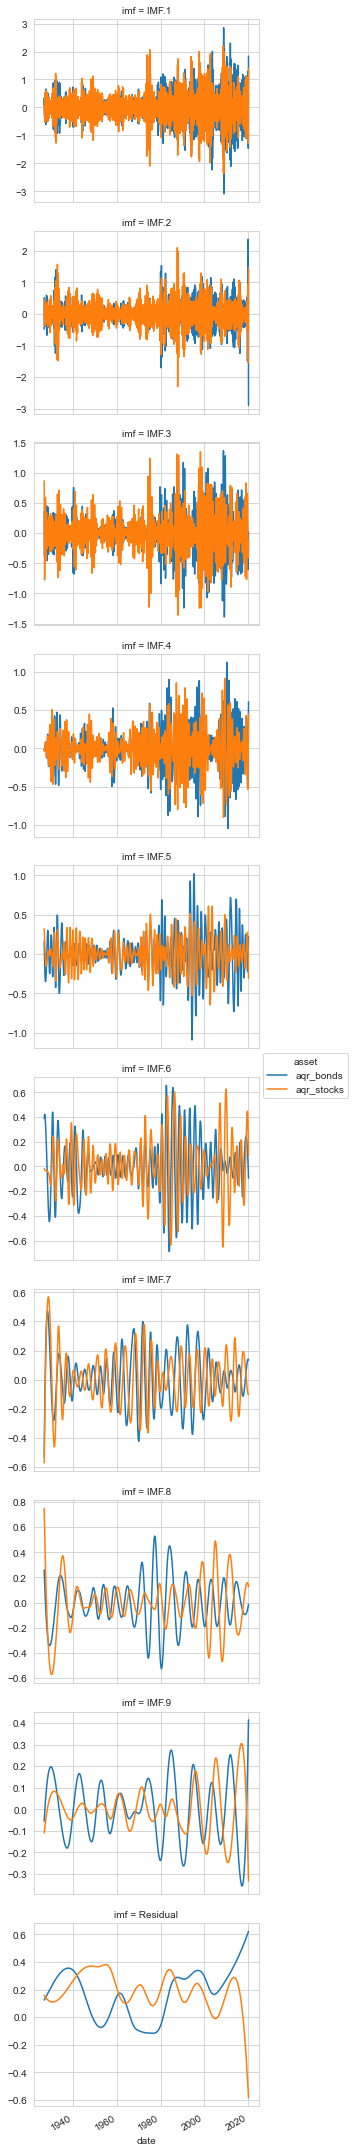

In [30]:
bimfx.plot(x="date", hue="asset", col="imf", col_wrap=1, sharey=False)

In [39]:
imf_oscillating_period(bimfx)

imf,IMF.1,IMF.2,IMF.3,IMF.4,IMF.5,IMF.6,IMF.7,IMF.8,IMF.9,Residual
asset,,,,,,,,,,
aqr_bonds,1.0,2.0,4.0,6.0,9.0,14.0,23.0,38.0,56.0,225.0
aqr_stocks,1.0,2.0,4.0,6.0,9.0,15.0,22.0,39.0,54.0,282.0


In [48]:
a = bimfx.to_series().unstack(["asset", "imf"]).corr()

In [56]:
a["aqr_stocks"].T["aqr_bonds"].style.background_gradient(axis=None, vmin=-1, vmax=1, cmap="bwr")

imf,IMF.1,IMF.2,IMF.3,IMF.4,IMF.5,IMF.6,IMF.7,IMF.8,IMF.9,Residual
imf,,,,,,,,,,
IMF.1,0.051762,-0.005741,0.006073,-0.014169,-0.008264,-0.003635,0.014167,0.014692,0.005957,0.011890
IMF.2,0.046274,0.129367,0.014946,-0.000415,-0.001517,0.007642,0.003861,0.007286,-0.005713,0.014550
IMF.3,0.017905,-0.008061,-0.020330,-0.033196,-0.006387,-0.003647,-0.003762,0.003058,-0.013549,0.017614
IMF.4,0.011070,-0.015089,0.029846,0.098914,-0.017218,-0.010390,0.012976,0.004779,-0.011796,-0.007804
IMF.5,-0.009278,-0.003228,0.001700,-0.013900,0.085916,0.106118,0.004785,-0.007231,0.004669,0.000600
IMF.6,-0.005733,0.000992,-0.025167,-0.005681,0.065333,0.174977,0.041201,0.012471,0.015784,0.036886
IMF.7,0.017500,0.006118,-0.009126,0.008786,-0.010849,-0.039322,0.243292,-0.026274,0.028728,0.000134
IMF.8,-0.004437,0.008596,0.004721,0.003654,0.010001,0.075248,-0.038772,0.078610,0.007840,-0.002464
IMF.9,-0.000845,-0.002243,0.030993,0.004605,0.003648,-0.013723,-0.029817,0.015895,-0.109415,0.092870


array([-7.04449097, -0.44426401,  0.03144698,  0.44825528,  0.88502543,
        4.87550992])